## Subsetting and retrieval of global sealevel/ssh observation data 

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt


To get an overview of the largest publicly available global sealevel observation datasets, we use `dfmt.ssh_catalog_subset()` with the `source` argument. For IOC and GESLA3 we also subset to highlight where they add significantly to the global spatial spatial coverage.

In [2]:
# ssc_catalog_gpd = dfmt.ssh_catalog_subset(source='ssc') # no data, only station locations
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')
ddl_gpd = dfmt.ssh_catalog_subset(source='ddl')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]


ddlpy.locations() cannot yet subset for 'Groepering.Code', ignored.
dropping stations with invalid coordinates:
                     X    Y              Naam   Code
Locatie_MessageID                                   
252970399          0.0  0.0  Crevecoeur boven  CREVB


>> reading coastlines: 2.71 sec


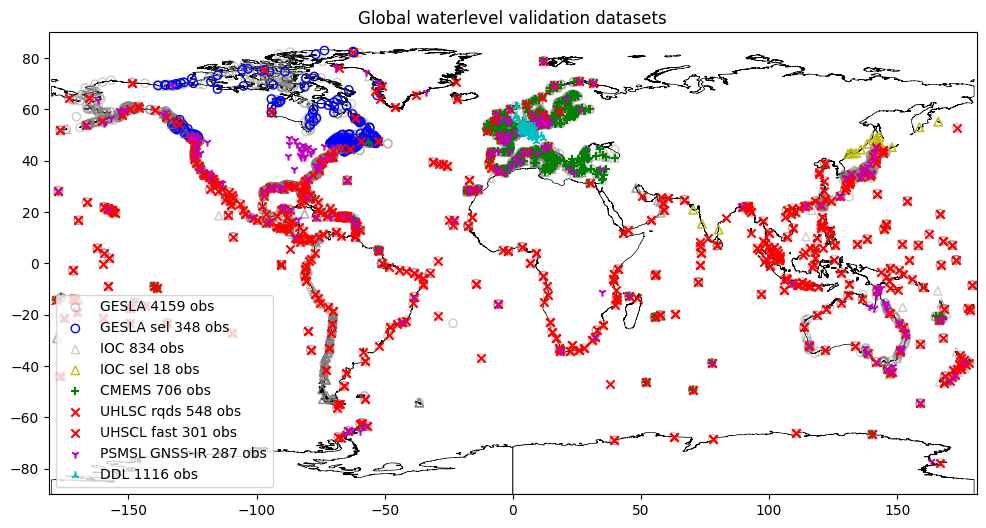

In [3]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="grey", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs", alpha=0.4)
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="grey", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs", alpha=0.4)
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHLSC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSCL fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")
ddl_gpd.geometry.plot(ax=ax, marker="2", color="c", label=f"DDL {len(ddl_gpd)} obs")

ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("Global waterlevel validation datasets")
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)


Next, we will subset all sources in time and space by providing more arguments to `dfmt.ssh_catalog_subset`. The stations with data in this period and area are plotted. 

retrieving psmsl-gnssir time extents for 9 stations: 1 2 3 4 5 6 7 8 9 
ddlpy.locations() cannot yet subset for 'Groepering.Code', ignored.
dropping stations with invalid coordinates:
                     X    Y              Naam   Code
Locatie_MessageID                                   
252970399          0.0  0.0  Crevecoeur boven  CREVB
>> reading coastlines: 1.23 sec


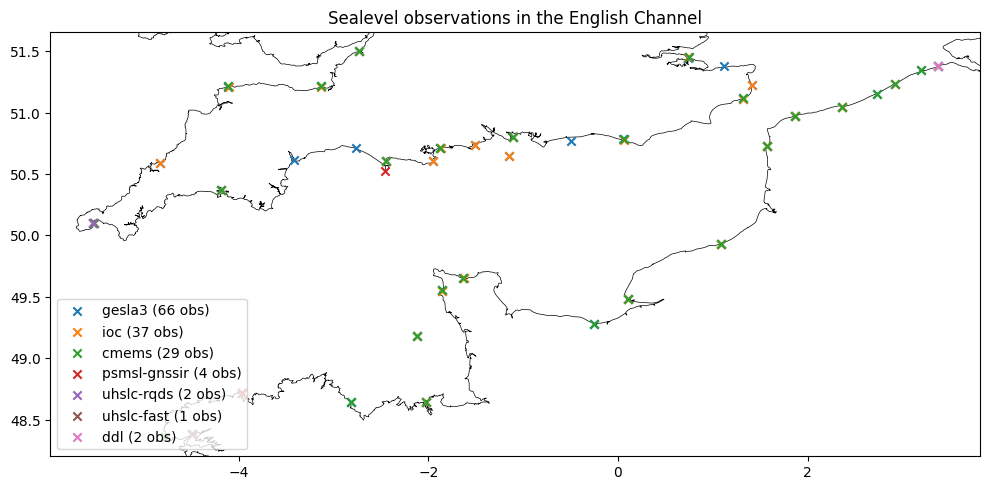

In [4]:
dir_output = "./sealevel_data_subset"
os.makedirs(dir_output, exist_ok=True)

lon_min, lon_max, lat_min, lat_max = -6, 3.5, 48, 51.5 # france
# lon_min, lon_max, lat_min, lat_max = 123, 148, 23, 47 # japan
# lon_min, lon_max, lat_min, lat_max = -20, 40, 25, 72 # europe
time_min, time_max = '2016-01-01','2016-02-01'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)
# TODO: no time subsetting supported for ddl yet
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
ddl_gpd_sel = dfmt.ssh_catalog_subset(source='ddl', **subset_kwargs)
subset_gpd_list = [gesla_catalog_gpd_sel, ioc_catalog_gpd_sel,
                  cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
                  uhslc_json_rqds_sel, uhslc_json_fast_sel,
                  ddl_gpd_sel]

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations in the English Channel")
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)


This data is retrieved with `dfmt.ssh_retrieve_data`. Since GESLA and IOC do not provide additional spatial coverage here, these datasets are skipped.

In [5]:
# retrieve data (for all except gesla and ioc)
subset_gpd_list_retrieve = [cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
                            uhslc_json_rqds_sel, uhslc_json_fast_sel,
                            ddl_gpd_sel]
for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)


retrieving data for 29 cmems stations: 1 2 3 4 5 6 7 8 9 10 [NODATA] 11 12 13 [NODATA] 14 15 16 17 18 19 20 21 [NODATA] 22 23 24 25 26 27 28 29 
retrieving data for 4 psmsl-gnssir stations: 1 2 3 4 
retrieving data for 2 uhslc stations: 1 2 
retrieving data for 1 uhslc stations: 1 
retrieving measwl data from DDL for station 1 of 2: CADZ
2016-01-01 00:00:00 2016-02-01 00:00:00


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


[NO DATA]
retrieving measwl data from DDL for station 2 of 2: CADZD
2016-01-01 00:00:00 2016-02-01 00:00:00


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

meta_dict: Grootheid.Code=WATHTE condition dropped 0 values in 'ddl_ssh_retrieve_data'
meta_dict: Groepering.Code=NVT condition dropped 120 values in 'ddl_ssh_retrieve_data'


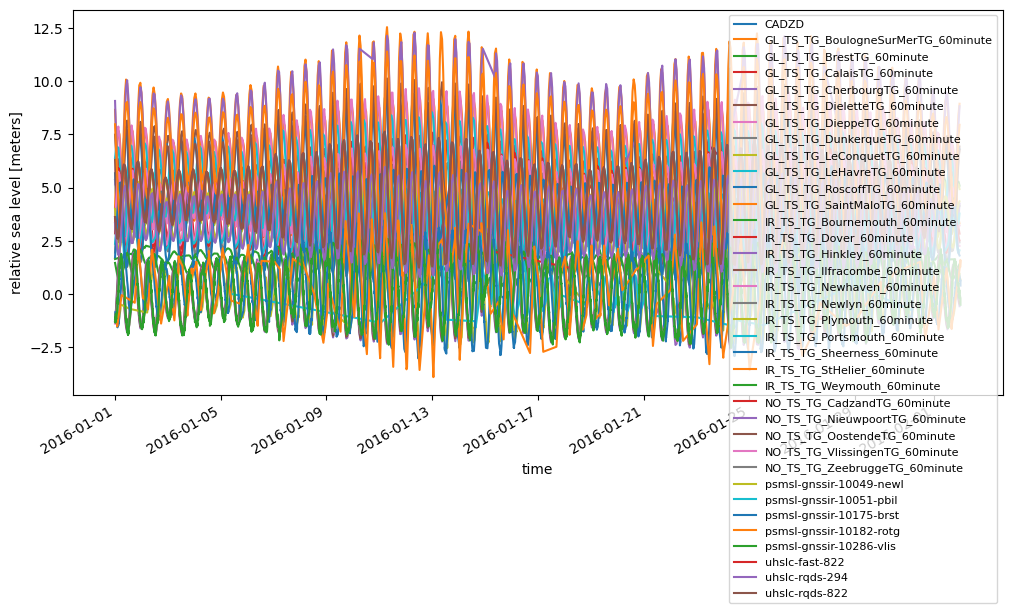

In [6]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
ax.legend(loc=1, fontsize=8)
